In [2]:
%matplotlib inline
import os
import json
import codecs
import numpy as np
import matplotlib.pyplot as plt
import openquake.hazardlib.geo.geodetic as geo
import hmtk.sources as src
import hmtk.plotting.seismicity.catalogue_plots as cp
from hmtk.seismicity.completeness.comp_stepp_1971 import Stepp1971
from hmtk.plotting.seismicity.completeness import plot_stepp_1972

from string import Template
from collections import OrderedDict
from hmtk.plotting.mapping import HMTKBaseMap
from hmtk.parsers.catalogue import CsvCatalogueParser
from hmtk.parsers.source_model.nrml04_parser import nrmlSourceModelParser
from hmtk.seismicity.selector import CatalogueSelector

In [3]:
# Marmaris, Turkey
target_lon = 28.25
target_lat = 36.85

sources_file = "../geology/MarmarisNearbySources21.xml"
catalogue_filename = '../seismicity/Marmaries-catalogue1_homogenised_cleaned.csv'

In [4]:
parser = CsvCatalogueParser(catalogue_filename) # From .csv to hmtk

# Read and process the catalogue content in a variable called "catalogue"
catalogue = parser.read_file() 

print 'Minimum magnitude: ', np.min(catalogue.data['magnitude'])
print 'Maximum magnitude: ', np.max(catalogue.data['magnitude'])
print 'Number of events: ', len(catalogue.data['magnitude'])
print 'Catalogue keys: '
print catalogue.data.keys()

Catalogue Attribute Identifier is not a recognised catalogue key
Minimum magnitude:  1.98
Maximum magnitude:  7.5
Number of events:  30546
Catalogue keys: 
['eventID', 'comment', 'sigmaMagnitude', 'hour', 'SemiMinor90', 'magnitude', 'Agency', 'second', 'longitude', 'month', 'depthError', 'flag', 'depth', 'magnitudeType', 'SemiMajor90', 'timeError', 'year', 'latitude', 'ErrorStrike', 'day', 'minute']


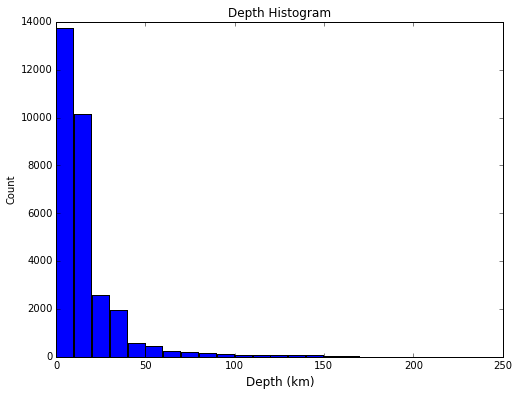

In [5]:
cp.plot_depth_histogram(catalogue, 10)

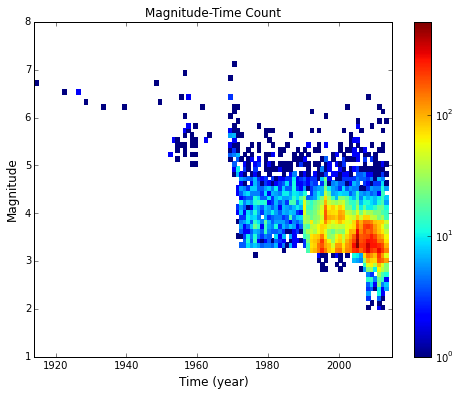

In [7]:
cp.plot_magnitude_time_density(catalogue, 0.1, 1)

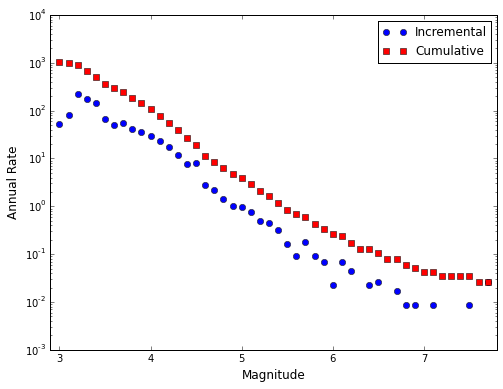

Completeness table guess
[[ 2004.      3. ]
 [ 1992.      3.3]
 [ 1972.      3.5]
 [ 1900.      6.5]]


In [9]:
completeness_table_guess = np.array([[2004, 3.0],
                                     [1992, 3.3], 
                                     [1972, 3.5], 
                                     [1900, 6.5]]) 
cp.plot_observed_recurrence(catalogue, completeness_table_guess, 0.1)
print 'Completeness table guess'
print completeness_table_guess

Completeness table using Stepp method (1971)
[[  2.01000000e+03   1.00000000e+00]
 [  2.00700000e+03   2.00000000e+00]
 [  1.99600000e+03   3.00000000e+00]
 [  1.97600000e+03   4.00000000e+00]
 [  1.95600000e+03   5.00000000e+00]
 [  1.91600000e+03   6.00000000e+00]]


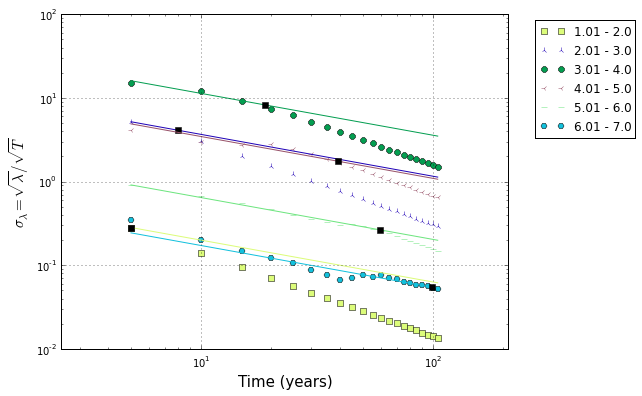

In [11]:
# Set up the configuration parameterss
complete_config = {'magnitude_bin': 1.0, 'time_bin': 5.0, 
               'increment_lock': False}

# Calling the method
completeness_algorithm = Stepp1971()

# Use the catalogue and completeness configuration
completeness_table = completeness_algorithm.completeness(
    catalogue, complete_config)

completeness_table = completeness_table[~np.isnan(completeness_table).any(axis=1)]

# Print the completeness table
print 'Completeness table using Stepp method (1971)'
print completeness_table

# Setting configuration for the completeness plot
plot_stepp_1972.create_stepp_plot(completeness_algorithm)


In [13]:
# Map configuration
span = 1 # deg
map_config = {"min_lon": target_lon - 2*span, 
              "max_lon": target_lon + 2*span, 
              "min_lat": target_lat - span, 
              "max_lat": target_lat + span, "resolution": "l"}

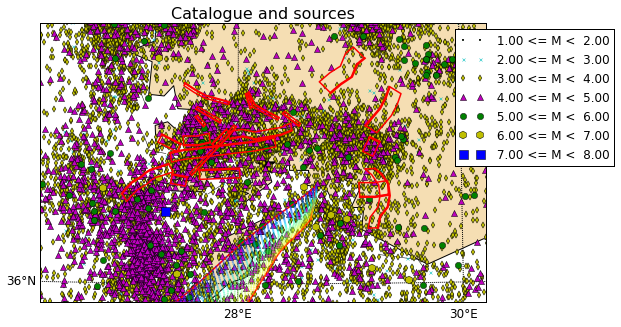

In [14]:
# Creating a basemap 
basemap1 = HMTKBaseMap(map_config, 'Catalogue and sources')

# Adding the catalogue to the basemap
basemap1.add_catalogue(catalogue, overlay=True)

# Reading the models 
parser = nrmlSourceModelParser(sources_file)

# Parse the seismic sources and save them in "source_model"
source_model = parser.read_file("Sources Around Marmaris")

# Adding the seismic sources
basemap1.add_source_model(source_model, area_border='r-', 
                          border_width=1.5, alpha=0.5, overlay=True)

# Add target
basemap1.add_size_scaled_points(target_lon, target_lat, 20, shape='*', 
                                colour='k', zorder=6)

In [15]:
selector = CatalogueSelector(catalogue, create_copy=True)

In [16]:
for source in source_model.sources:
    if isinstance(source, src.area_source.mtkAreaSource): 
        source.select_catalogue(selector)
        print 'Area source %s, name %s, # of events %8.0f' % (
            source.id, source.name, source.catalogue.get_number_events())
        #subcatalogue_area = selector.    

In [17]:
d_km = 10*np.ones_like(source_model.sources)
d_km[-1] = 30
for i, source in enumerate(source_model.sources):
    if isinstance(source, src.simple_fault_source.mtkSimpleFaultSource): 
        source.select_catalogue(selector, d_km[i])
    elif isinstance(source, src.complex_fault_source.mtkComplexFaultSource): 
        source.select_catalogue(selector, d_km[i]) 
        
    print '%s: %s, %d events wihin %g km' % (
        source.id, source.name, source.catalogue.get_number_events(), d_km[i])

TRCS913: Ula-Oren, 1311 events wihin 10 km
TRCS394: Datca Horst North Boundary 1, 299 events wihin 10 km
TRCS391: Gokova Oren Fault Zone 1, 620 events wihin 10 km
TRCS396: Gokova Transfer Fault, 827 events wihin 10 km
TRCS413: Mugla Yatagan Fault 2, 283 events wihin 10 km
TRCS414: Mugla Yatagan Fault 3, 135 events wihin 10 km
TRCS392: Gokova Oren Fault Zone 2, 526 events wihin 10 km
TRCS412: Mugla Yatagan Fault 1, 203 events wihin 10 km
TRCS393: Gokova Oren Fault Zone 3, 563 events wihin 10 km
TRCS397: Milas - Gulluk Fault Zone, 167 events wihin 10 km
TRCS415: Karova Milas Fault Zone, 139 events wihin 10 km
TRCS398: Dorttepe, 152 events wihin 10 km
TRCS395: Datca Horst North Boundary 2, 163 events wihin 10 km
TRCS338: Bodrum, 150 events wihin 10 km
TRCS271: Golgelidag Horst West Boundary - Tavas, 63 events wihin 10 km
GRCS965: Kos, 364 events wihin 10 km
TRCS293: Fethiye, 92 events wihin 10 km
TRCS268: Golgelidag Horst East Boundary - Akalan, 329 events wihin 10 km
TRCS267: Golgelidag 

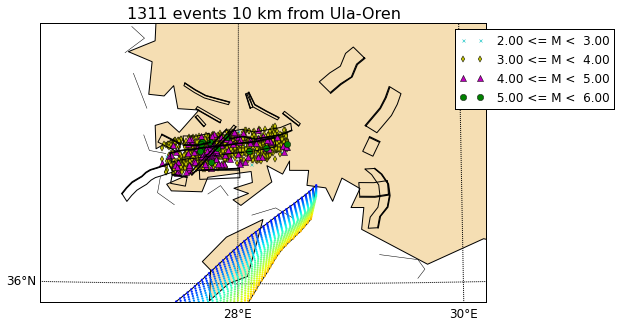

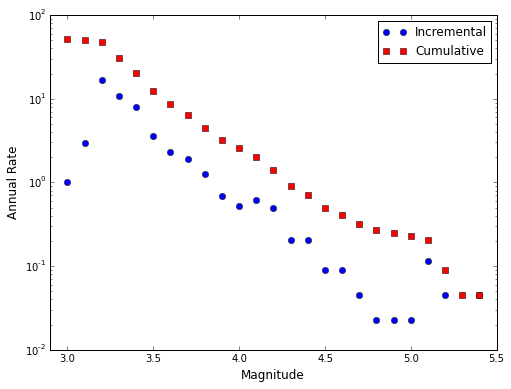

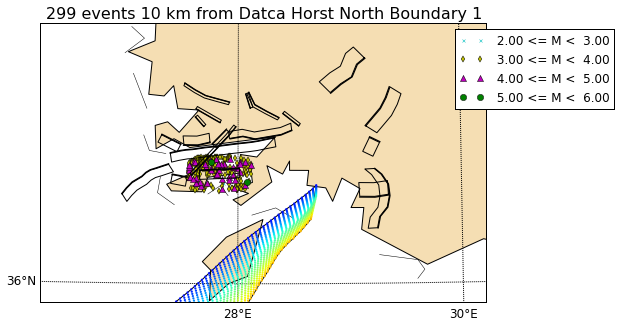

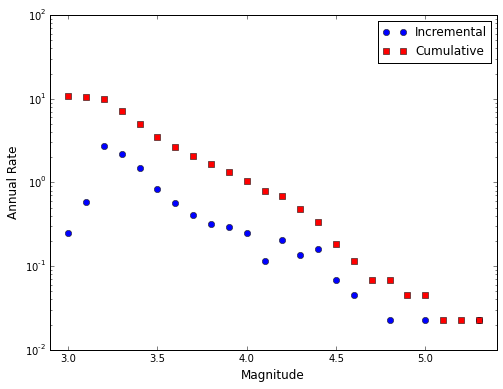

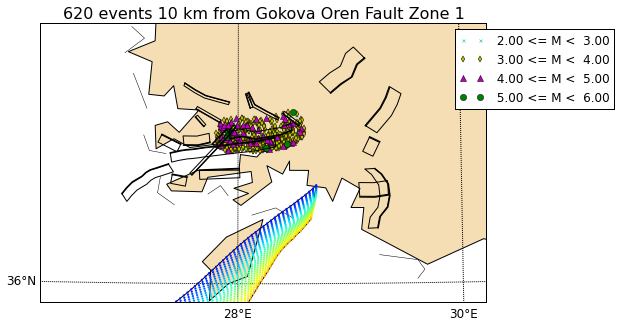

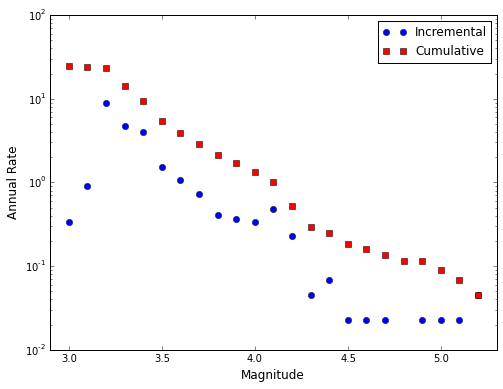

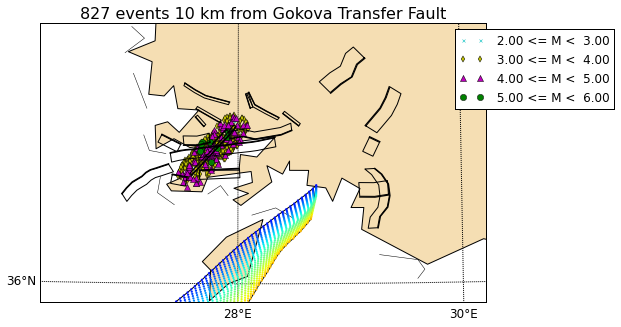

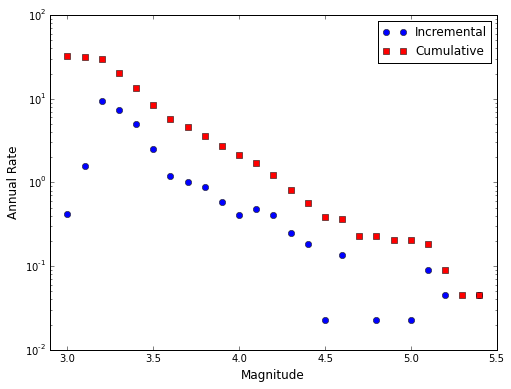

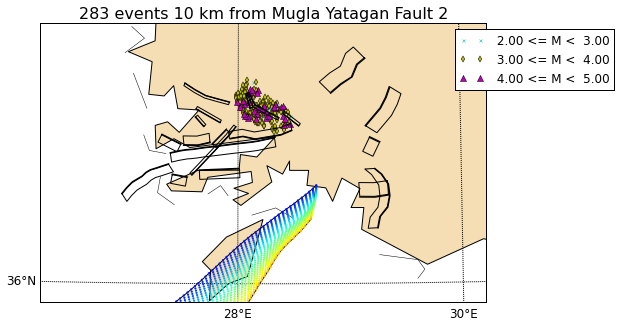

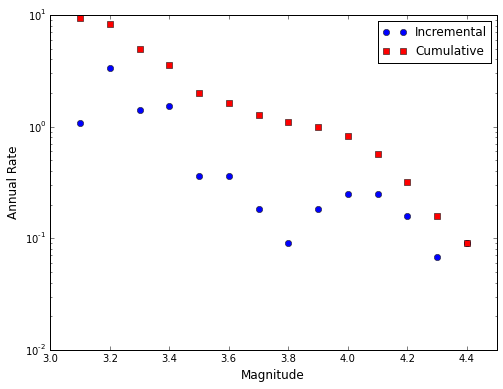

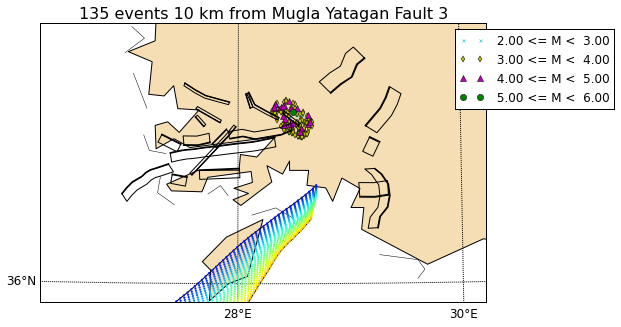

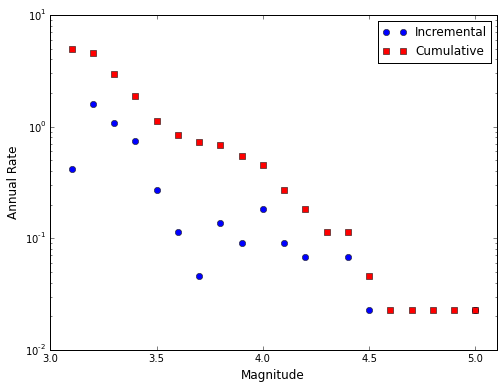

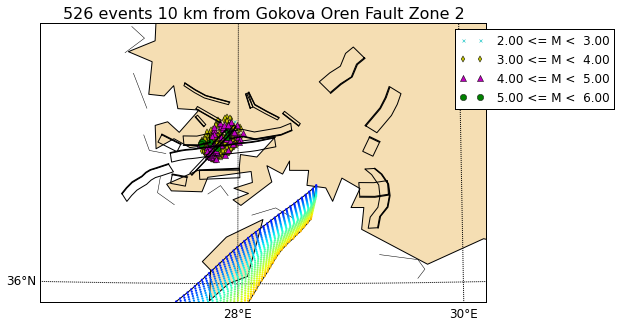

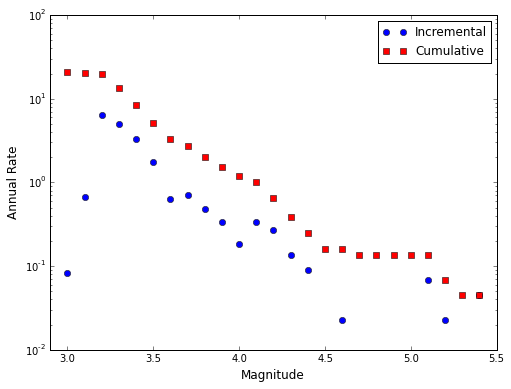

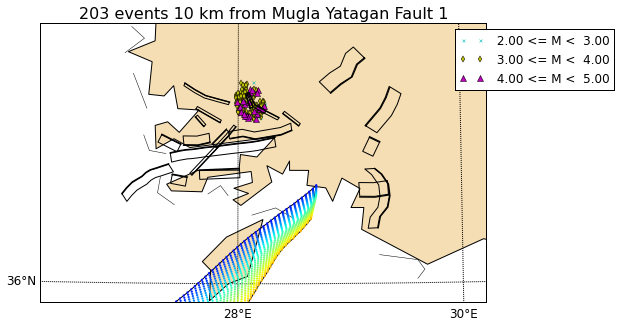

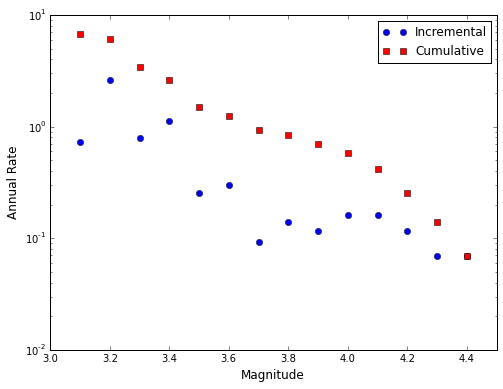

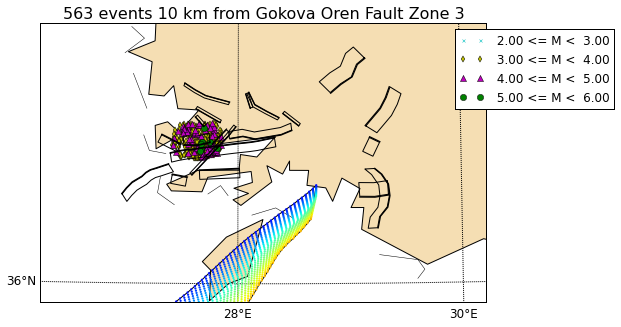

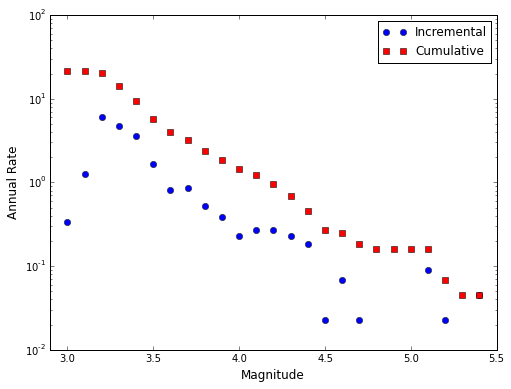

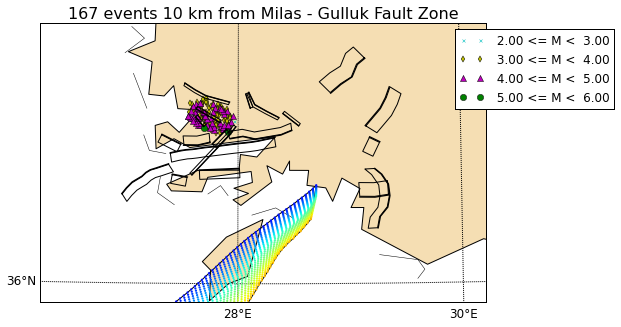

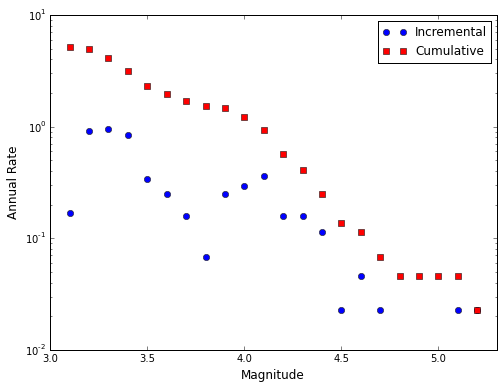

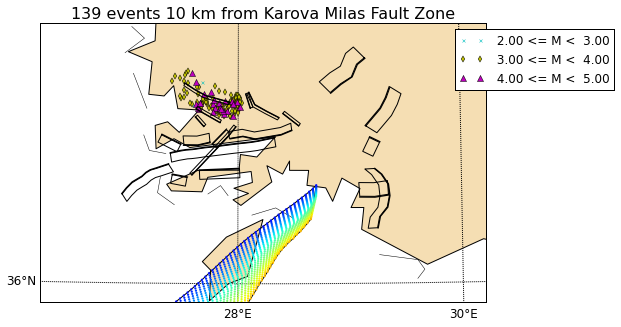

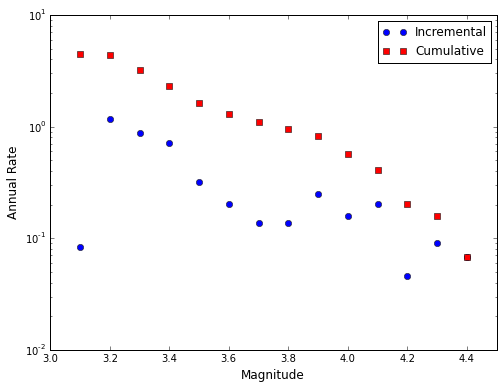

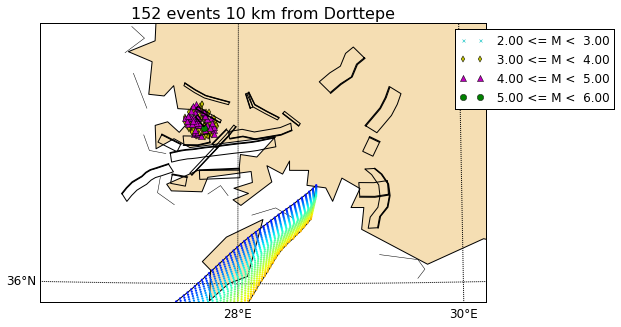

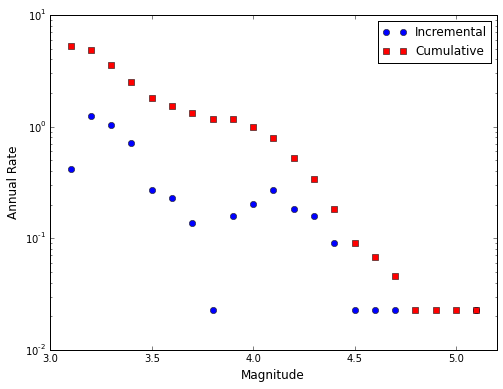

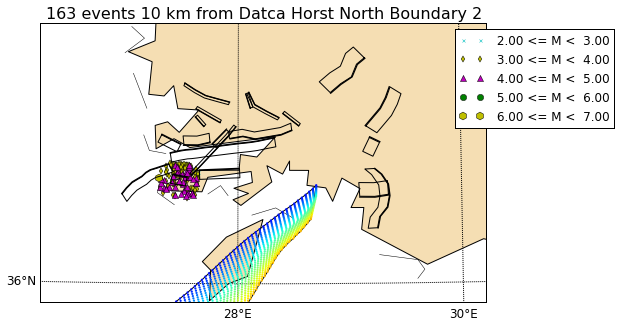

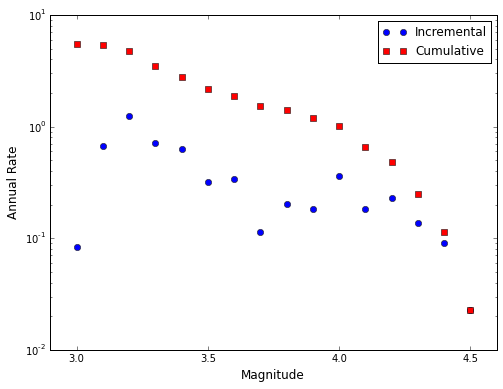

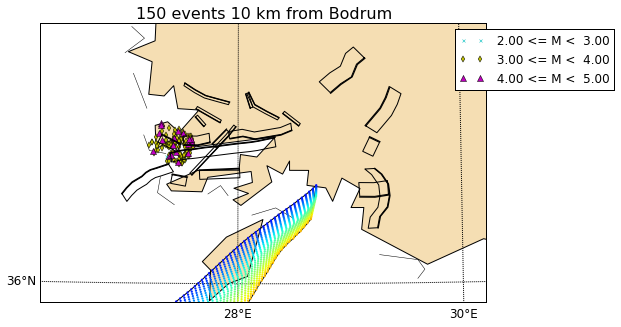

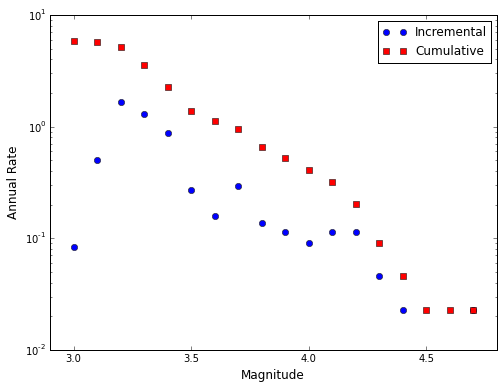

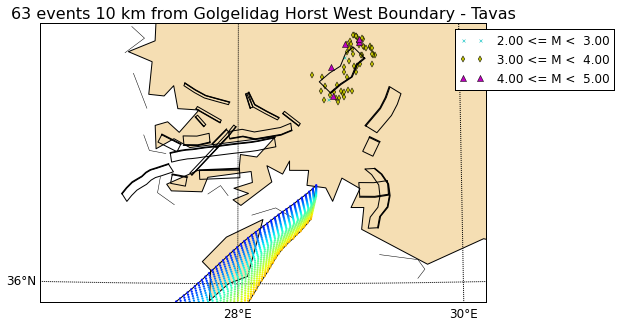

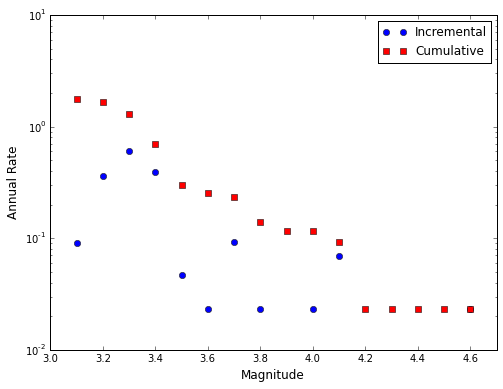

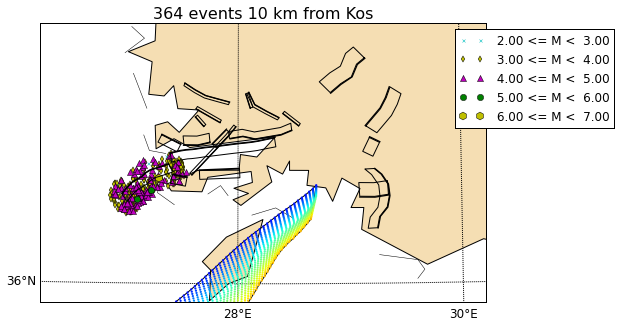

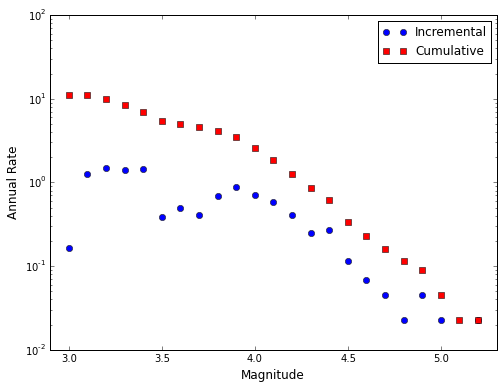

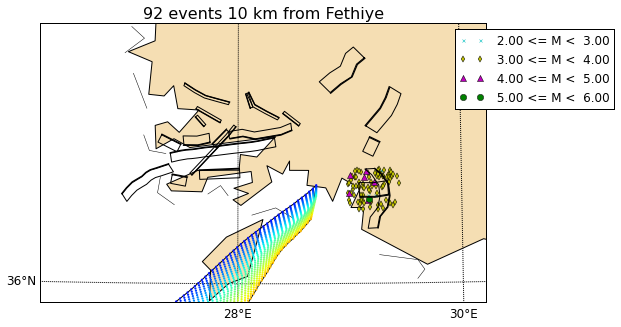

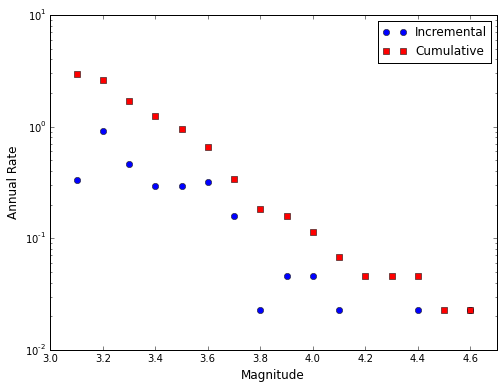

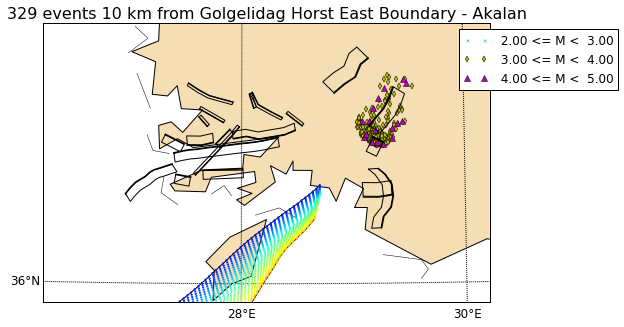

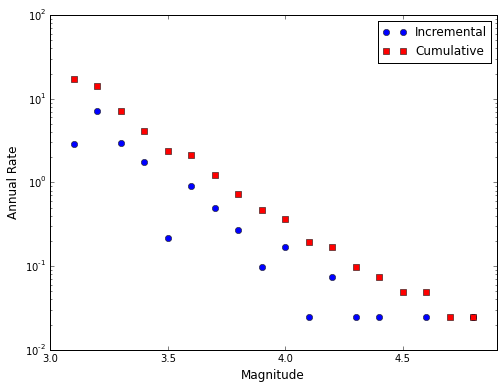

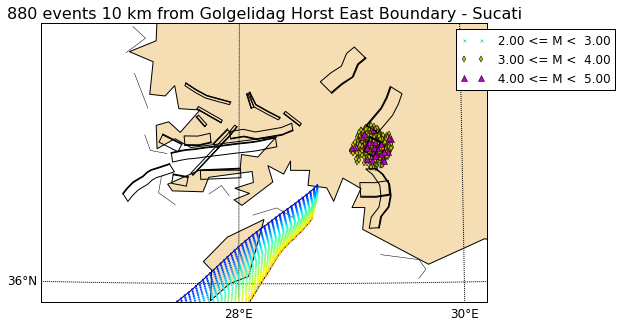

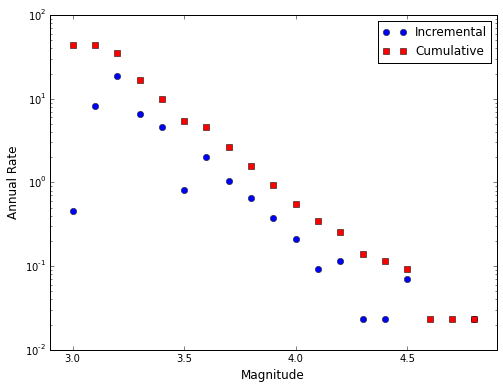

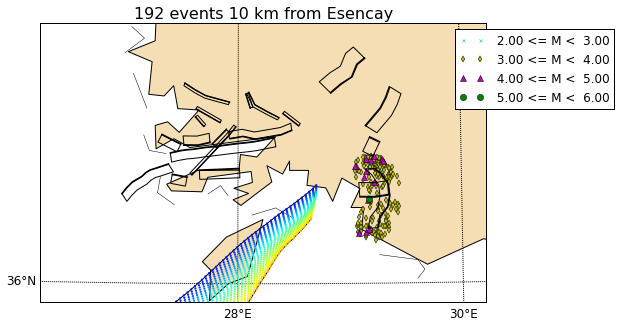

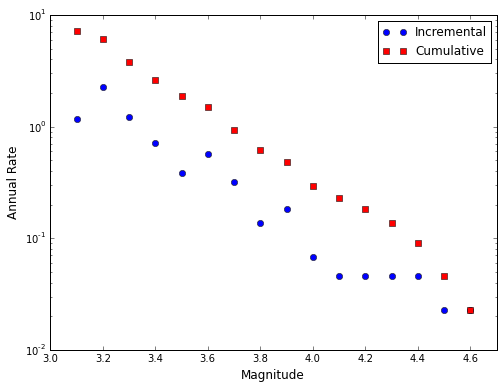

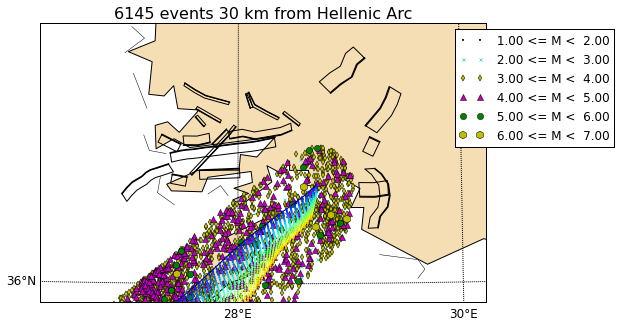

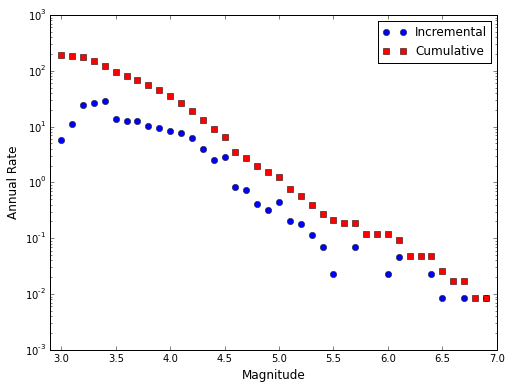

In [19]:
for i, source in enumerate(source_model.sources):
    n_events = source.catalogue.get_number_events()
    if n_events < 5: continue
    basemap = HMTKBaseMap(
        map_config, '%d events %d km from %s' % (n_events, d_km[i], source.name))
    basemap.add_catalogue(source.catalogue, overlay=True)
    basemap.add_source_model(source_model, area_border='k-')
    
    cp.plot_observed_recurrence(source.catalogue, completeness_table_guess, 0.1)